# Transfer learning

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated convolutional neural networks (CNNs) trained by Google, Microsoft, and others on high-performance computing (HPC) clusters equipped with GPUs to be repurposed and used to solve domain-specific problems. With transfer learning, for example, you can take a CNN trained to distinguish between dogs and cats and modify it to distinguish between hot dogs and hambugers. And you can do it on a laptop computer — no GPU required.

Many pretrained CNNs are available in the public domain, and several are included with Keras. In this exercise, you will use Keras and Microsoft's [ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) pretrained CNN to build a network that distinguishes with a high degree of accuracy between images containing hot dogs, pizza, and sushi.

![](Images/food.png)

## Load training and testing images

The first step is to load the images that will be used for training and testing and to label the images with 0 for hot dogs, 1 for pizza, and 2 for sushi. We'll start by defining a function for loading images from the file system and affixing labels to them, and another function for displaying images. We will also define four Python lists to hold the images used for training and testing (`x_train` and `x_test`) and the labels used for training and testing (`y_train` and `y_test`).

In [1]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(path + file, target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x_train = []
y_train = []
x_test = []
y_test = []

Load hot-dog images for training and show the first few.

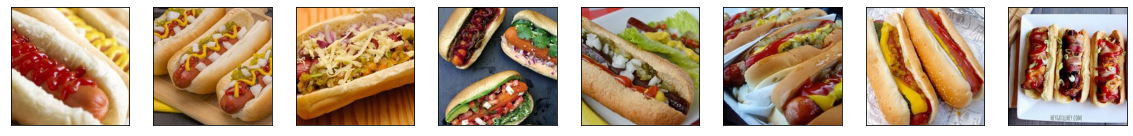

In [2]:
images, labels = load_images_from_path('HotDog/train/hot_dog/', 0)
show_images(images)
    
x_train += images
y_train += labels

Load pizza images for training and show the first few.

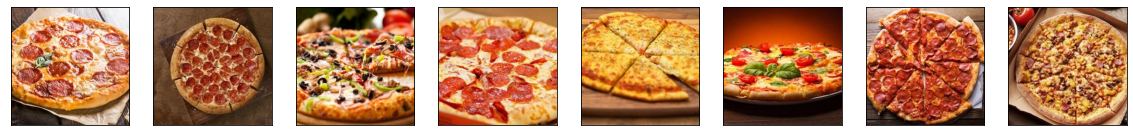

In [3]:
images, labels = load_images_from_path('HotDog/train/pizza/', 1)
show_images(images)
    
x_train += images
y_train += labels

Load sushi images for training and show the first few.

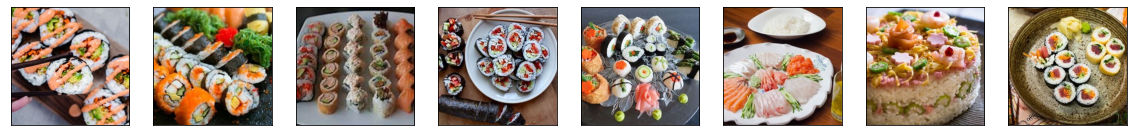

In [4]:
images, labels = load_images_from_path('HotDog/train/sushi/', 2)
show_images(images)
    
x_train += images
y_train += labels

Load hot-dog images for testing and show the first few.

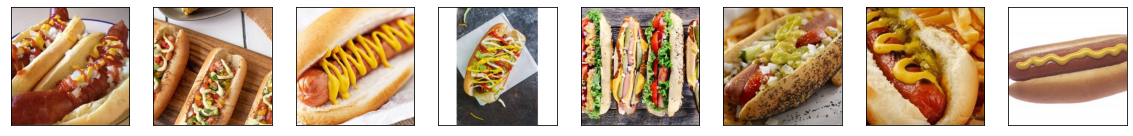

In [5]:
images, labels = load_images_from_path('HotDog/test/hot_dog/', 0)
show_images(images)
    
x_test += images
y_test += labels

Load pizza images for testing and show the first few.

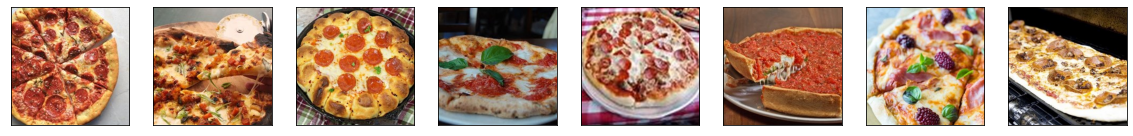

In [6]:
images, labels = load_images_from_path('HotDog/test/pizza/', 1)
show_images(images)
    
x_test += images
y_test += labels

Load sushi images for testing and show the first few.

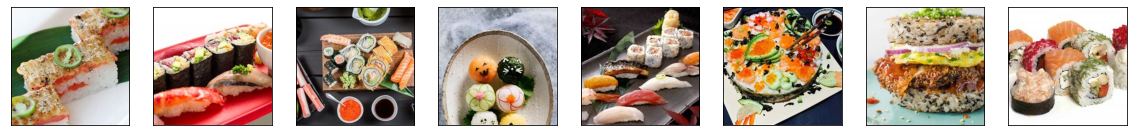

In [7]:
images, labels = load_images_from_path('HotDog/test/sushi/', 2)
show_images(images)
    
x_test += images
y_test += labels

Preprocess the training and testing images, and use Keras's [`to_categorical`](https://keras.io/api/utils/python_utils/#to_categorical-function) function to one-hot-encode the training and testing labels. The images must be preprocessed the same way the images used to train `ResNet50V2` were preprocessed. This is accomplished by passing them to the `preprocess_input` function and dividing the resulting values by 255.

In [8]:
from keras.utils import to_categorical
from keras.applications.resnet50 import preprocess_input

x_train = preprocess_input(np.array(x_train)) / 255
x_test = preprocess_input(np.array(x_test)) / 255
    
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

## Train a network with the output from ResNet50V2

Rather than create a CNN of our own, we will load `ResNet50V2` minus the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet](http://www.image-net.org/) dataset. We will then run our training and test images through it to extract features from them.

In [9]:
from keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train = base_model.predict(x_train)
x_test = base_model.predict(x_test)

Now define a simple network for doing classification and train it with the output from `ResNet50V2`.

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train_encoded, validation_data=(x_test, y_test_encoded), batch_size=10, epochs=20)

Epoch 1/20
15/15 [==============================] - 2s 115ms/step - loss: 7.6316 - accuracy: 0.7333 - val_loss: 16.8087 - val_accuracy: 0.7067
Epoch 2/20
15/15 [==============================] - 2s 107ms/step - loss: 1.7759 - accuracy: 0.9533 - val_loss: 17.1491 - val_accuracy: 0.7133
Epoch 3/20
15/15 [==============================] - 2s 108ms/step - loss: 0.9783 - accuracy: 0.9600 - val_loss: 9.2360 - val_accuracy: 0.8533
Epoch 4/20
15/15 [==============================] - 2s 109ms/step - loss: 0.3564 - accuracy: 0.9867 - val_loss: 12.2673 - val_accuracy: 0.8533
Epoch 5/20
15/15 [==============================] - 2s 108ms/step - loss: 0.9239 - accuracy: 0.9733 - val_loss: 7.5435 - val_accuracy: 0.9067
Epoch 6/20
15/15 [==============================] - 2s 107ms/step - loss: 0.0294 - accuracy: 0.9933 - val_loss: 10.6887 - val_accuracy: 0.8933
Epoch 7/20
15/15 [==============================] - 2s 107ms/step - loss: 0.8075 - accuracy: 0.9933 - val_loss: 10.7712 - val_accuracy: 0.8867
E

How well did the network train? Let's plot the training accuracy and validation accuracy for each epoch.

[]

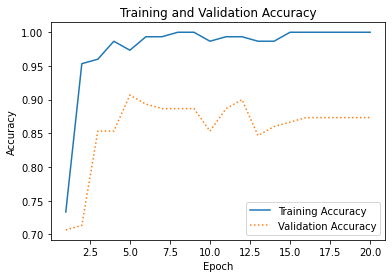

In [11]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Use a confusion matrix to visualize how well the network performed during testing.

Text(89.133125, 0.5, 'Actual label')

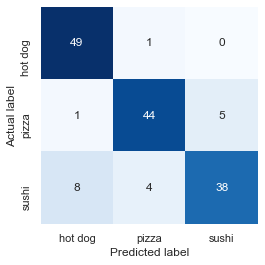

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
labels = ['hot dog', 'pizza', 'sushi']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## Make a prediction

What happens if the network is used to classify an image that it hasn't seen before? And how do you go about making such a prediction? Let's take a hot-dog image and see how the network classifies it. The first step is to load the image.

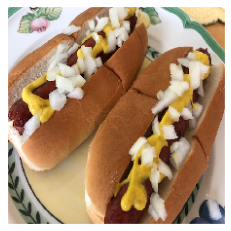

In [13]:
x = image.load_img('HotDog/samples/hot-dog.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Next, we preprocess the image and run it through `ResNet50V2`'s feature-extraction layers, and then run the output through our newly trained classification layers.

In [14]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

y = base_model.predict(x)
predictions = model.predict(y)
print(predictions[0])

[1. 0. 0.]


The model predicts with a high degree of certainty that the image contains an example of class 0. Here's how the model scored the image for all three classes.

In [15]:
def show_labeled_probs(prediction):
    print('hot dog: ' + str(prediction[0]))
    print('pizza: ' + str(prediction[1]))
    print('sushi: ' + str(prediction[2]))

show_labeled_probs(predictions[0])

hot dog: 1.0
pizza: 0.0
sushi: 0.0


Now let's try it with a sushi image. Start by loading the image.

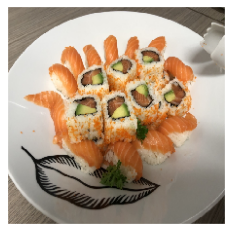

In [16]:
x = image.load_img('HotDog/samples/sushi.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image and make a prediction.

In [17]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

y = base_model.predict(x)
predictions = model.predict(y)
show_labeled_probs(predictions[0])

hot dog: 0.0
pizza: 2.9811202e-25
sushi: 1.0


`ResNet50V2` wasn't trained to recognize sushi in images, but our network was.